# 🐶 Using Transfer Learning and TensorFlow 2.x to Classify Different Dog Breeds

Who's that doggy in the window?

Dogs are incredible. But have you ever been sitting at a cafe, seen a dog and not known what breed it is? I have. And then someone says, "it's an English Terrier" and you think, how did they know that?

In this project we're going to be using machine learning to help us identify different breeds of dogs.

To do this, we'll be using data from the [Kaggle dog breed identification competition](https://www.kaggle.com/c/dog-breed-identification/overview). It consists of a collection of 10,000+ labelled images of 120 different dog breeds.

This kind of problem is called multi-class image classification. It's multi-class because we're trying to classify mutliple different breeds of dog. If we were only trying to classify dogs versus cats, it would be called binary classification (one thing versus another).

Multi-class image classification is an important problem because it's the same kind of technology Tesla uses in their self-driving cars or Airbnb uses in atuomatically adding information to their listings.

Since the most important step in a deep learng problem is getting the data ready (turning it into numbers), that's what we're going to start with.

We're going to go through the following TensorFlow/Deep Learning workflow:

1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, the 3 sets, X & y).
3. Choose and fit/train a model ([TensorFlow Hub](https://www.tensorflow.org/hub), ´tf.keras.applications´, [TensorBoard](https://www.tensorflow.org/tensorboard), [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
6. Save, sharing and reloading your model (once you're happy with the results).

For preprocessing our data, we're going to use TensorFlow 2.x. The whole premise here is to get our data into Tensors (arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.

For our machine learning model, we're going to be using a pretrained deep learning model from TensorFlow Hub.

The process of using a pretrained model and adapting it to your own problem is called **transfer learning**. We do this because rather than train our own model from scratch (could be timely and expensive), we leverage the patterns of another model which has been trained to classify images.

In [1]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("TF hub version: ", hub.__version__)

TF version:  2.9.0
TF hub version:  0.12.0


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Check for GPU availability
print("GPU", "available (Yessss!!!)" if tf.config.list_physical_devices("GPU") else "Not availabe :/")

GPU available (Yessss!!!)


## Get workspace ready
* Import TensorFlow 2.x ✅
* Import TensorFlow Hub ✅
* Make sure we're using a GPU ✅

## Get data ready (turn it into tensors)

With all machine learning model,s our data has to be in numerical format. So that's what we'll be doing first: Turning our images into tensors (numerical representation).

Let's start by accssing our data and checking out the labels.

In [4]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [5]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


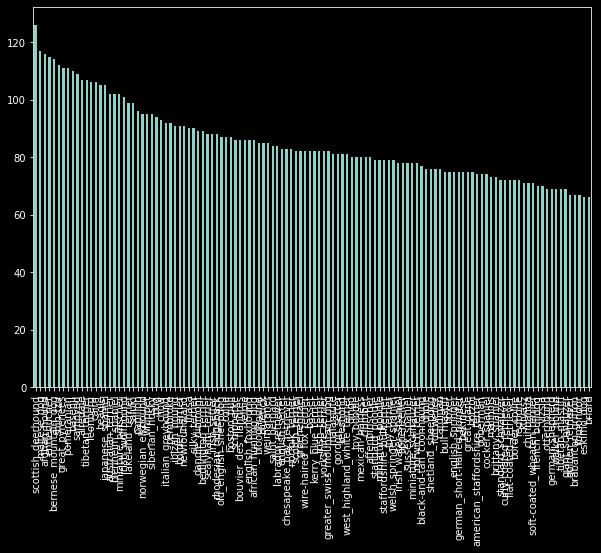

In [6]:
# How many images of each breed are there?
labels_csv["breed"].value_counts().plot.bar(figsize=(10,7));

In [7]:
labels_csv["breed"].value_counts().median()

82.0

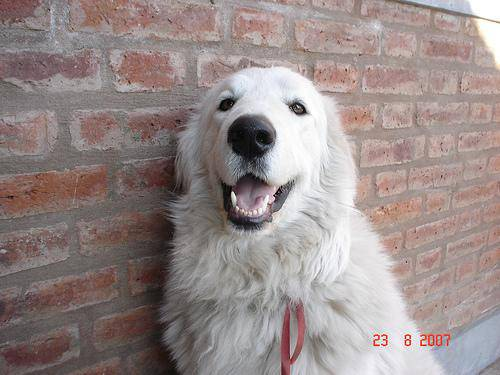

In [8]:
# Let's view an image
from IPython.display import Image
Image("train/0a0c223352985ec154fd604d7ddceabd.jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames.

In [9]:
# Create pathnames from image ID's
filenames = ["train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'train/001cdf01b096e06d78e9e5112d419397.jpg',
 'train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'train/002a283a315af96eaea0e28e7163b21b.jpg',
 'train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
import os
os.listdir("train/")[:10]

['000bec180eb18c7604dcecc8fe0dba07.jpg',
 '001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '001cdf01b096e06d78e9e5112d419397.jpg',
 '00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '002211c81b498ef88e1b40b9abf84e1d.jpg',
 '00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '002a283a315af96eaea0e28e7163b21b.jpg',
 '003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
# Check wheter number of filenames matches number of image files
if len(os.listdir("train/")) == len(filenames):
    print("Filenames match actual amount of files!!! Proceed.")
else:
    print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!!! Proceed.


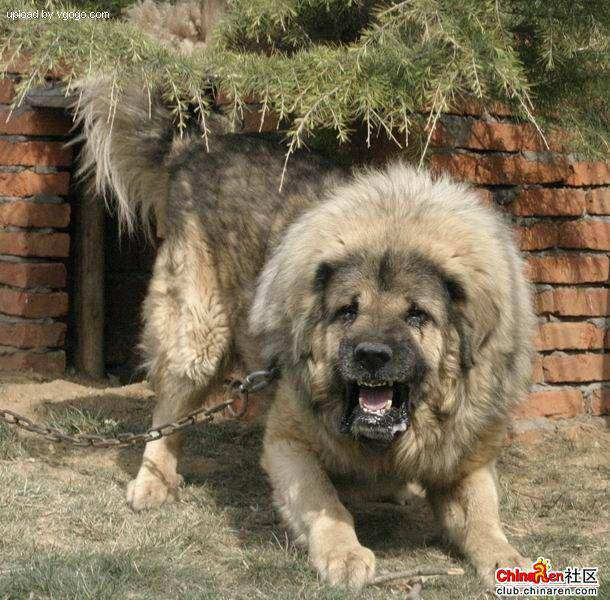

In [12]:
# One more check
Image(filenames[9_000])

In [13]:
labels_csv["breed"][9_000]

'tibetan_mastiff'

Since we've got our training image filepaths in a list, let's prepare our labels.

In [14]:
import numpy as np
labels = labels_csv["breed"]
# labels = labels_csv["breed"].to_numpy() does the same as below
labels = np.array(labels)
labels, len(labels)

(array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
        'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object),
 10222)

In [15]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
    print("Number of labels matches number of filenames")
else:
    print("Number do not match!")

Number of labels matches number of filenames


In [16]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds[:10], len(unique_breeds)

(array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle'], dtype=object),
 120)

In [17]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [18]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2], len(boolean_labels)

([array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False]),
  array([False, False, False, Fa

In [19]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19], dtype=int64),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [20]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our on validation set
SInce the dataset from Kaggle does not come with a validation set, we're going to create our own.

In [21]:
# Setup X & y variables
X = filenames
y = boolean_labels


We're going to start off experimenting with ~1000 images and increase as needed.

In [22]:
# Set number of images to use for experimenting
NUM_IMAGES = 1_000 

In [23]:
# Let's split data into train and validation
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(
    X[:NUM_IMAGES], 
    y[:NUM_IMAGES],
    test_size=0.2,
    random_state=42
)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [24]:
# Let's have a geez at the training data
X_train[:2], y_train[:2]

(['train/00bee065dcec471f26394855c5c2f3de.jpg',
  'train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, Fa

## Preprocessing images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

### Before we do, let's see what importing an image looks like

In [25]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape, image.max(), image.min()

((257, 350, 3), 255, 0)

In [26]:
# Turn image into a Tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

In [27]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
    """
    Takes an image file path and turns it into a Tensor
    """
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpg into numerical Tensor with 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the colour channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image
    image = tf.image.resize(image, size=[img_size, img_size])

    return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to preocess 10_000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

IN order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, labels)`

In [28]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the associated label,
    precesses the image and returns a tuple if (image, label).
    """
    image = process_image(image_path)
    return image, label

In [29]:
(process_image(X[42]), y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form `(image, label)`, let's make a function to turn all of our data (`X` & `y`) into batches.

In [30]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) und label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data is input (no labels).
    """
    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch

    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((
            tf.constant(X), # filepaths
            tf.constant(y)  # labels
        ))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    # Otherwise it must be a training dataset
    else:
        print("Creating training data batches...")
        data = tf.data.Dataset.from_tensor_slices((
            tf.constant(X),
            tf.constant(y)
        ))
        # Shuffle the pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))
        # Create image label tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)
        # Turn the data into batches
        data_batch = data.batch(BATCH_SIZE)
        return data_batch


In [31]:
# Create training and validation data batches
train_data = create_data_batches(
    X_train,
    y_train
)
val_data = create_data_batches(
    X_val,
    y_val,
    valid_data=True
)

Creating training data batches...
Creating validation data batches...


In [32]:
# Check out the different attributes of data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing data batches
Our data is now in batches, however these can be a little hard to understand/comprehend, let's visualize them.

In [33]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch
    """
    # Setup the figure
    plt.figure(figsize=(10,10))
    # Loop through 25 images
    for i in range(25):
        # Create subplots (5 rows, 5 cols)
        ax = plt.subplot(5, 5, i+1)
        # Display image
        plt.imshow(images[i])
        # Add the image label as title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn grid lines off
        plt.axis("off")

In [34]:
len(train_data)

25

In [35]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels, len(train_images), len(train_labels)

(array([[[[0.37382573, 0.40519828, 0.4130414 ],
          [0.38799897, 0.41937152, 0.42721465],
          [0.40000004, 0.43137258, 0.43921572],
          ...,
          [0.5039641 , 0.52780867, 0.47479737],
          [0.43758726, 0.4748947 , 0.3854959 ],
          [0.28204638, 0.31935382, 0.22492102]],
 
         [[0.3778274 , 0.40919995, 0.4170431 ],
          [0.3938288 , 0.42520136, 0.4330445 ],
          [0.40286243, 0.43423498, 0.4420781 ],
          ...,
          [0.46030152, 0.48414603, 0.4311347 ],
          [0.33180752, 0.3554619 , 0.35363087],
          [0.16372526, 0.19223543, 0.20497176]],
 
         [[0.38450631, 0.41587886, 0.423722  ],
          [0.40050772, 0.43188027, 0.4397234 ],
          [0.40978825, 0.4411608 , 0.44900393],
          ...,
          [0.11911794, 0.14268956, 0.09747917],
          [0.269276  , 0.28823942, 0.37719285],
          [0.06745404, 0.07707466, 0.20151477]],
 
         ...,
 
         [[0.12230683, 0.14583625, 0.1379931 ],
          [0.13768

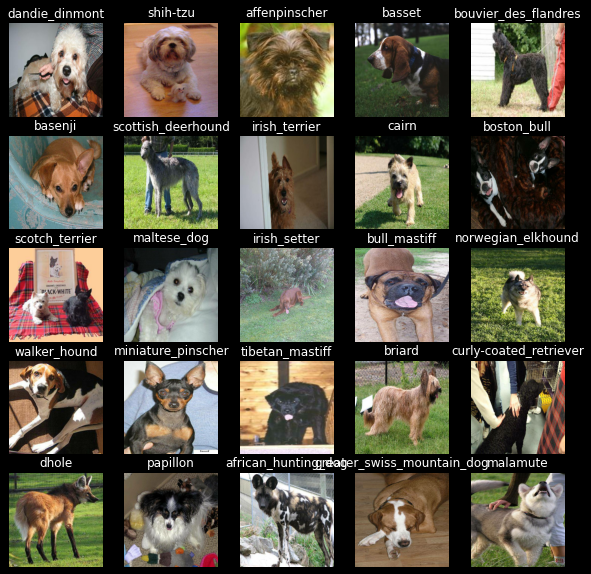

In [36]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

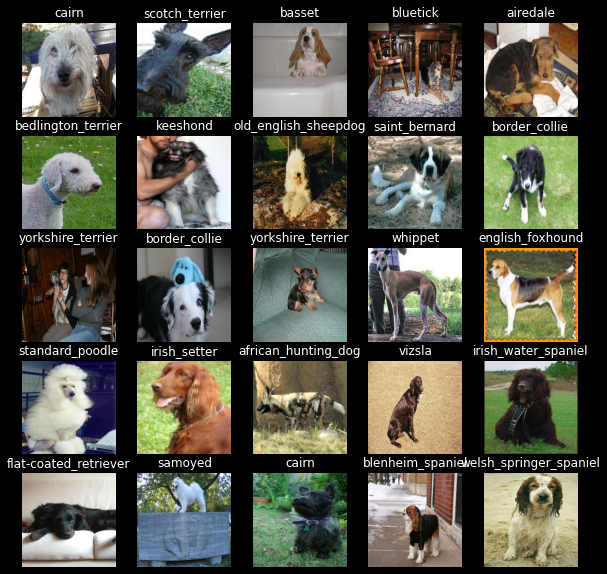

In [37]:
# Visualize validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things, we need to define:
* The input shape (images shape in the form of Tensors) to the model
* The output shape (images labels in the form of Tensors) of the model
* The URL of the model to use

In [38]:
# Setup input shape
INPUT_SHAPE =[None, IMG_SIZE, IMG_SIZE, 3]
# Setup output shape
OUTPUT_SHAPE = len(unique_breeds)
# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got our inputs, outputs and model ready to go, let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that)
* Compiles the model (says it should be evaluated and improved)
* Build the model (tells the model the input shape it'll be getting)
* Returns the model

 All of the steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [74]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with: ", MODEL_URL)

    # Setup model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL), # Layer 1: input layer
        tf.keras.layers.Dense(
            units=OUTPUT_SHAPE, 
            activation="softmax"
        ) # Layers 2: output layer
    ])

    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    model.build(INPUT_SHAPE)

    return model

In [75]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_5 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helperfunctions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping, which prevents our model from training for too long.

### Tensorboard Callback
To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension ✅
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function. ✅
3. Visualize our models training logs with the  `$tensorboard` magic function (we'll do this after model training).


In [64]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [76]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    """
    Create a log directory for storing TensorBoard logs.
    """
    logdir = os.path.join(
        "Logs",
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    )

    return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [77]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3
)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [78]:
NUM_EPOCHS = 100

Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [86]:
# Build a function to train and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model = create_model()
    model.summary()
    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()
    # Fit the model to the data passing it the callbacks we created
    model.fit(
        x=train_data,
        epochs=NUM_EPOCHS,
        validation_data=val_data,
        validation_freq=1,
        callbacks=[tensorboard, early_stopping]
    )
    return model

In [87]:
# Fit the model to the data
model = train_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_8 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_8 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 8s 145ms/step - loss: 4.5950 - accuracy: 0.0862 - val_loss: 3.4672 - val_accuracy: 0.2400
Epoch 2/100
25/25 [==============================] - 5s 198ms/step - loss: 1.6510 - accuracy: 0.6938 - val_loss: 2.1960 - val_accuracy: 0.4750
Epoch 3/100
25/25 [==============================] - 5

**Question:** Looks like our model is overfitting because it is performing far better on the training set than the validation set. What are some ways to prevent model overfitting in deep learning neural networks?

**Note:** Overfitting to begin wi is a good thing! It means our model  is learning!!!

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will acess the logs directory we created earlier and visualize its contents.

In [70]:
#%tensorboard --logdir C:\Selbststudium\Udemy\Udemy_ZTM_Data_Science\dog-breed\Logs

> Try to find out how to use TensorBoard within MS Code!

## Making and evaluating predictions using a trained model

In [90]:
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [93]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 123ms/step


array([[3.5591683e-04, 5.2541131e-05, 5.8898859e-04, ..., 4.7705919e-04,
        9.4413308e-06, 2.2794628e-03],
       [2.1708055e-04, 2.6957691e-03, 5.2143401e-03, ..., 6.6668763e-05,
        5.9901748e-04, 3.0908526e-05],
       [7.5677322e-06, 8.8345536e-05, 1.5020659e-04, ..., 1.6740784e-04,
        8.1361330e-05, 1.8324063e-04],
       ...,
       [2.5822937e-06, 4.6546761e-06, 6.4336423e-06, ..., 7.9420633e-06,
        1.5569896e-05, 6.1608243e-06],
       [1.2674183e-03, 8.8288500e-05, 4.9217946e-05, ..., 1.8327782e-04,
        1.4011376e-05, 9.4366567e-03],
       [4.7011956e-04, 5.5830631e-05, 4.3426160e-04, ..., 1.5306147e-03,
        1.5022850e-04, 1.0825533e-04]], dtype=float32)

In [113]:
print(f"Shape of predictions: {predictions.shape}")
print(f"Amount of unique breeds: {len(unique_breeds)}")
print(f"Length of one single prediction: {len(predictions[0])}")
print(f"Sum of predictions should be one: {np.sum((predictions[0]))}")

Shape of predictions: (200, 120)
Amount of unique breeds: 120
Length of one single prediction: 120
Sum of predictions should be one: 1.0


In [111]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability): {np.max(predictions[index])}, Index: {np.argmax(predictions[index])}")
print(f"Breed: {unique_breeds[np.argmax(predictions[index])]}")

[2.64323062e-05 1.13947659e-04 8.44926908e-05 7.48711136e-06
 4.20451164e-04 1.39117492e-05 3.79910125e-05 2.64087110e-04
 2.10838066e-03 1.64404623e-02 3.58898569e-06 3.69333520e-07
 3.94819886e-04 1.50964840e-03 4.69734310e-04 1.00923877e-03
 6.63982064e-06 3.15493293e-04 4.60470947e-05 8.07976685e-05
 1.46161537e-05 4.83423588e-04 8.61829449e-06 1.14242466e-05
 1.68747362e-03 2.80110762e-05 1.26096738e-05 1.73760454e-05
 1.28994317e-04 1.06298794e-05 3.98189477e-05 3.56304349e-06
 3.67117491e-06 1.46889151e-05 4.84279553e-06 5.16126829e-06
 3.47384848e-05 4.43646422e-05 1.22779766e-05 2.45586604e-01
 9.25139466e-05 1.30134401e-06 7.49362633e-04 1.51774293e-06
 7.65134610e-05 1.26089290e-05 3.53549585e-05 4.26525425e-04
 4.03691047e-06 7.58382812e-05 5.45491139e-06 2.08073707e-05
 4.05286701e-05 3.51888913e-04 9.97560619e-06 5.97142862e-05
 8.24710060e-06 1.43196803e-05 7.69631242e-06 4.64755431e-06
 6.23774167e-06 1.06469706e-04 3.06774132e-06 1.26908781e-05
 7.48109087e-05 1.528647

Having the above functionality is great, but we want to be able to do it at scale.

It would be even better if we could see the image the prediction was made on.

**Note:** PRediction probabilities are also know as confidence levels.

In [114]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_breeds[np.argmax(prediction_probabilities)]

In [118]:
# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'irish_setter'

Since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [122]:
# First try without function
images_ = []
labels_ = []

# Loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(label)

images_[0], labels_[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [137]:
# Create a function to unbatch
def unbatchify(data):
    """
    Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels.
    """
    images = []
    labels = []
    # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

In [138]:
val_images, val_labels = unbatchify(val_data)

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some functions to make these all a bit more visualized. 

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images an integer
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [152]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth and image for sample n
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    # Get the pred label
    pred_label = get_pred_label(pred_prob)

    # Plot image and remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Change the color of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    # Change plot title to be predicted, probability of prediction and truth label
    plt.title(f"{pred_label} - {np.max(pred_prob)*100:2.0f}% - {true_label}", color=color)

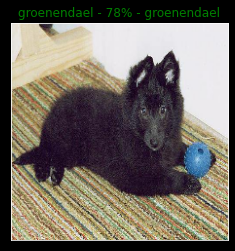

In [154]:
plot_pred(prediction_probabilities=predictions, labels=val_labels, images=val_images, n=77)